In [1]:
import os, sys
import numpy as np
from astropy.constants import m_e
from astropy.coordinates import Distance
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import Image


#### AGNpy classes ####
from agnpy.spectra import PowerLaw
from agnpy.emission_regions import Blob
from agnpy.synchrotron import Synchrotron
from agnpy.compton import SynchrotronSelfCompton
import warnings
warnings.filterwarnings('ignore')

def plot_setup(log_scale = 'none'):
    
    if log_scale == 'x':
        ax.set_xscale('log')
        
    elif log_scale == 'y':
        ax.set_yscale('log')
        
    elif log_scale == 'both':
        ax.set_xscale('log')
        ax.set_yscale('log')
        
    ax.tick_params(which = 'both', direction = 'in', top = True, right = True,
                  grid_alpha = 0.5, grid_linestyle = '--')
    ax.grid(True)



In this notebook we explore how the spectrum changes when we change the parameters that define the emission region
and the electron distribution.

Let's start by keeping the emission region fixed and tweaking the electron distribution.
We still consider a PowerLaw distribution but we allow the variation of the total energy content $W_e$ and slope $p$ as well as the maximum and minimum Lorentz factors of the electrons.

In [2]:
# We keep the emission region parameters fixed
R_b = 1e16 * u.cm                    
V_b = 4/3 * np.pi * np.power(R_b, 3) 
z = Distance(1e27, unit = u.cm).z    
delta_D = 10                         
Gamma = 10                           
B = 1 * u.G  
# Build a grid in W_e and p and define an electron distribution for each pair of values.
# For now we will keep γ_min and γ_max fixed

total_energies = np.power(10.,np.arange(42,52.1, .1)) 
powers = np.arange(2.0, 3.01, 0.01)

shape = (len(total_energies), len(powers))
e_distributions = []

for i, w in enumerate(total_energies):

    this_w = w * u.Unit('erg')
    these_e_distributions = []
    for j, p in enumerate(powers):
        
        n_e = PowerLaw.from_total_energy(W = this_w, V = V_b, p = p, 
                                         gamma_min = 1e2, gamma_max = 1e5, mass = m_e)
        these_e_distributions.append(n_e)

    e_distributions.append(these_e_distributions)
    
# e_distributions now contains a matrix of electron distributions defined on a grid of W_e and p       
# From here, we can define a matrix of emission regions in a very similar fashion

blobs = []
for i in range(len(total_energies)):
    
    these_blobs = []
    for j in range(len(powers)):
        
        this_blob = Blob(R_b, z, delta_D, Gamma, B, n_e = e_distributions[i][j])
        these_blobs.append(this_blob)

    blobs.append(these_blobs)


### Synchrotron

In [3]:
# For each blob we can now define a spectrum
# as in the fixed parameter case, let's explore how each spectrum is affected individually
# Before combining them into our total spectrum
# This time, we'll only look at the case that takes Self-Absorption into account

synch_seds = []
for i in range(len(total_energies)):

    these_seds = []
    for j in range(len(powers)):
        blob = blobs[i][j]
        synch = Synchrotron(blob, ssa = True)
        nu_syn = np.logspace(8, 23) * u.Hz
        synch_sed = synch.sed_flux(nu_syn)
        these_seds.append(synch_sed)

    synch_seds.append(these_seds)

(1e-16, 1e-07)

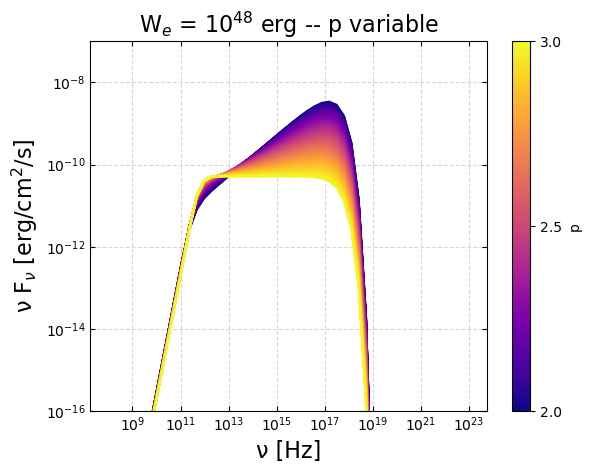

In [4]:

# Let's plot the results
# First let's see how the individual parameters affect the spectrum, by fixing one and variating the other

# Here we fix the total energy of the distribution at W_e ~ 10**48 erg (W_e = total_energies[60])
fig, ax = plt.subplots()


cmap = mpl.cm.get_cmap('plasma', len(powers))

# make a dummie mappable for the colorbar
c = np.arange(1, len(powers)+1)
v = [float(_) for _ in powers]
dummie_cax = ax.scatter(c, c, c = v, cmap = cmap)

# clear axis
ax.cla()

plot_setup('both')

for j, p in enumerate(powers):
    
    ax.plot(nu_syn, synch_seds[60][j], color = cmap(j))
fig.colorbar(dummie_cax, ticks = [v[0], v[50], v[100]], label = 'p')

ax.set_xlabel('ν [Hz]',fontsize = 16)
ax.set_ylabel(r'ν F$_{\nu}$ [erg/cm$^{2}$/s]', fontsize = 16)
ax.set_title('W$_{e}$ = 10$^{48}$ erg -- p variable', fontsize = 16)
ax.set_ylim(1e-16, 1e-7)

(1e-18, 10.0)

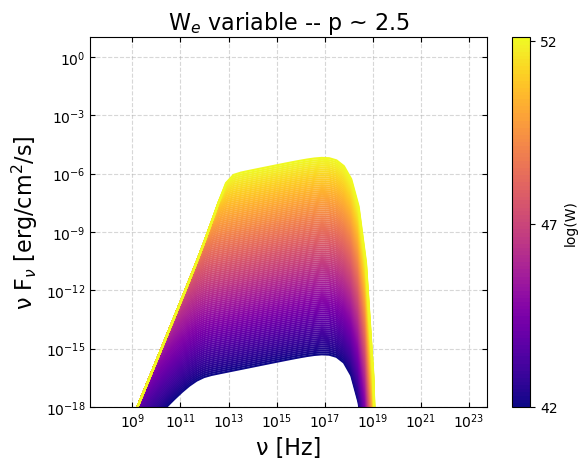

In [11]:
# Let's now do the same, but fixing p = 2.5 (p = powers[50]) and variating W_e
fig, ax = plt.subplots()

cmap = mpl.cm.get_cmap('plasma', len(total_energies))

# make a dummie mappable for the colorbar
log_energies = np.log10(total_energies)
c = np.arange(1, len(log_energies)+1)
v = [float(_) for _ in log_energies]
dummie_cax = ax.scatter(c, c, c = v, cmap = cmap)

# clear axis
ax.cla()

plot_setup('both')

for i, w in enumerate(total_energies):
    
    ax.plot(nu_syn, synch_seds[i][50], color = cmap(i))
    
fig.colorbar(dummie_cax, ticks = [v[0], v[50], v[100]], label = 'log(W)')

ax.set_xlabel('ν [Hz]',fontsize = 16)
ax.set_ylabel(r'ν F$_{\nu}$ [erg/cm$^{2}$/s]', fontsize = 16)
ax.set_title('W$_{e}$ variable -- p ~ 2.5', fontsize = 16)
ax.set_ylim(1e-18, 1e1)

In [6]:
# HERE WE WILL INCLUDE A PLOT THAT ALLOWS US TO VARY BOTH PARAMETERS THROUGH SLIDERS.

### SSC

In [7]:
# Now we do a similar process with the SSC spectrum
# Again we only consider the one obtained over a SSA spectrum.
nu_ssc = np.logspace(15, 30) * u.Hz

ssc_seds = []
for i in range(len(total_energies)):

    these_seds = []
    for j in range(len(powers)):
        blob = blobs[i][j]
        ssc = SynchrotronSelfCompton(blob, ssa = True)
        ssc_sed = ssc.sed_flux(nu_ssc)
        these_seds.append(ssc_sed)

    ssc_seds.append(these_seds)

(1e-16, 1e-07)

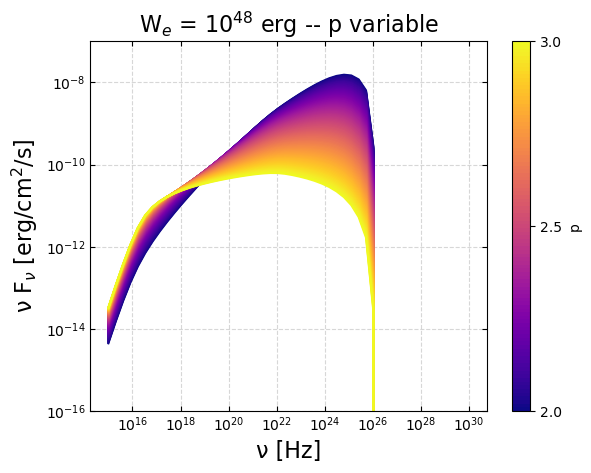

In [9]:
# Let's plot the SSC spectrum for fixed W_e
# W_e ~ 10**48 erg (W_e = total_energies[60])
fig, ax = plt.subplots()


cmap = mpl.cm.get_cmap('plasma', len(powers))

# make a dummie mappable for the colorbar
c = np.arange(1, len(powers)+1)
v = [float(_) for _ in powers]
dummie_cax = ax.scatter(c, c, c = v, cmap = cmap)

# clear axis
ax.cla()

plot_setup('both')

for j, p in enumerate(powers):
    
    ax.plot(nu_ssc, ssc_seds[60][j], color = cmap(j))
fig.colorbar(dummie_cax, ticks a= [v[0], v[50], v[100]], label = 'p')

ax.set_xlabel('ν [Hz]',fontsize = 16)
ax.set_ylabel(r'ν F$_{\nu}$ [erg/cm$^{2}$/s]', fontsize = 16)
ax.set_title('W$_{e}$ = 10$^{48}$ erg -- p variable', fontsize = 16)
ax.set_ylim(1e-16, 1e-7)

(1e-18, 10.0)

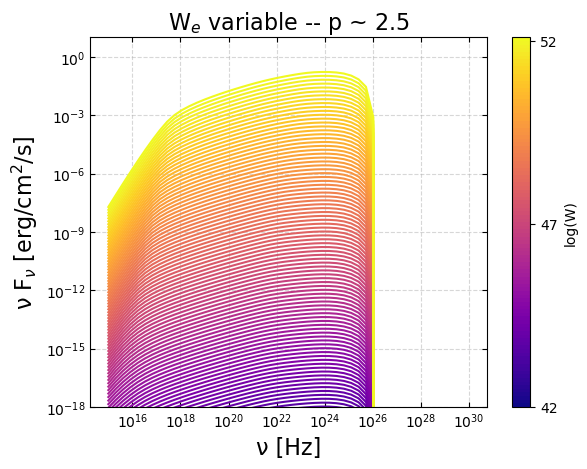

In [10]:
# Now we fix p = 2.5 (p = powers[50]) and variating W_e
fig, ax = plt.subplots()


cmap = mpl.cm.get_cmap('plasma', len(total_energies))

# make a dummie mappable for the colorbar
log_energies = np.log10(total_energies)
c = np.arange(1, len(log_energies)+1)
v = [float(_) for _ in log_energies]
dummie_cax = ax.scatter(c, c, c = v, cmap = cmap)

# clear axis
ax.cla()

plot_setup('both')

for i, w in enumerate(total_energies):
    
    ax.plot(nu_ssc, ssc_seds[i][50], color = cmap(i))
    
fig.colorbar(dummie_cax, ticks = [v[0], v[50], v[100]], label = 'log(W)')

ax.set_xlabel('ν [Hz]',fontsize = 16)
ax.set_ylabel(r'ν F$_{\nu}$ [erg/cm$^{2}$/s]', fontsize = 16)
ax.set_title('W$_{e}$ variable -- p ~ 2.5', fontsize = 16)
ax.set_ylim(1e-18, 1e1)

In [13]:
# WE WILL ADD A SLIDERS PLOT HERE

### Total SED

In [15]:
# Similarly to the fixed parameters case we define the spectra on the same range of frequencies
# so that we can properly sum the two emissions
nu= np.logspace(8, 30) * u.Hz

total_seds = []
synch_seds = []
ssc_seds = []
for i in range(len(total_energies)):

    these_seds = []
    these_synchs = []
    these_sscs = []
    for j in range(len(powers)):
        blob = blobs[i][j]

        synch = Synchrotron(blob, ssa = True)
        synch_sed = synch.sed_flux(nu)
        these_synchs.append(synch_sed)

        ssc = SynchrotronSelfCompton(blob, ssa = True)
        ssc_sed = ssc.sed_flux(nu)
        these_sscs.append(ssc_sed)

        total_sed = synch_sed + ssc_sed
        these_seds.append(total_sed)

    total_seds.append(these_seds)
    synch_seds.append(these_synchs)
    ssc_seds.append(these_sscs)
    

In [16]:
# Let's plot the total spectrum for fixed W_e
# W_e ~ 10**48 erg (W_e = total_energies[60])
fig, ax = plt.subplots()


cmap = mpl.cm.get_cmap('plasma', len(powers))

# make a dummie mappable for the colorbar
c = np.arange(1, len(powers)+1)
v = [float(_) for _ in powers]
dummie_cax = ax.scatter(c, c, c = v, cmap = cmap)

# clear axis
ax.cla()

plot_setup('both')

for j, p in enumerate(powers):
    
    ax.plot(nu, total_seds[60][j], color = cmap(j))
fig.colorbar(dummie_cax, ticks a= [v[0], v[50], v[100]], label = 'p')

ax.set_xlabel('ν [Hz]',fontsize = 16)
ax.set_ylabel(r'ν F$_{\nu}$ [erg/cm$^{2}$/s]', fontsize = 16)
ax.set_title('W$_{e}$ = 10$^{48}$ erg -- p variable', fontsize = 16)
ax.set_ylim(1e-16, 1e-7)

SyntaxError: invalid syntax. Perhaps you forgot a comma? (2040679090.py, line 21)

In [ ]:
# Now we fix p = 2.5 (p = powers[50]) and variating W_e
fig, ax = plt.subplots()


cmap = mpl.cm.get_cmap('plasma', len(total_energies))

# make a dummie mappable for the colorbar
log_energies = np.log10(total_energies)
c = np.arange(1, len(log_energies)+1)
v = [float(_) for _ in log_energies]
dummie_cax = ax.scatter(c, c, c = v, cmap = cmap)

# clear axis
ax.cla()

plot_setup('both')

for i, w in enumerate(total_energies):
    
    ax.plot(nu, total_seds[i][50], color = cmap(i))
    
fig.colorbar(dummie_cax, ticks = [v[0], v[50], v[100]], label = 'log(W)')

ax.set_xlabel('ν [Hz]',fontsize = 16)
ax.set_ylabel(r'ν F$_{\nu}$ [erg/cm$^{2}$/s]', fontsize = 16)
ax.set_title('W$_{e}$ variable -- p ~ 2.5', fontsize = 16)
ax.set_ylim(1e-18, 1e1)

In [ ]:
# WE WILL AD A SLIDERS PLOT HERE